##Load Images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
path = '/content/drive/MyDrive/Kampus Merdeka/Dataset/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
import os

##Pre-Processing Training Dataset

In [3]:
df = pd.read_csv('/content/Labels.csv', delimiter=';')

In [4]:
df

,Nama File,Label
0,IMG-20240507-WA0006.jpg,Natural
1,IMG-20240507-WA0007.jpg,Machine
2,IMG-20240507-WA0008.jpg,filtering
3,IMG-20240507-WA0009.jpg,mining
4,IMG-20240507-WA0010.jpg,Variance
...,...,...
115,IMG-20240507-WA0121.jpg,language
116,IMG-20240507-WA0122.jpg,prediktif
117,IMG-20240507-WA0123.jpg,Regression
118,IMG-20240507-WA0124.jpg,Statistik


##Visualisasi Histogram Training Text Lengths

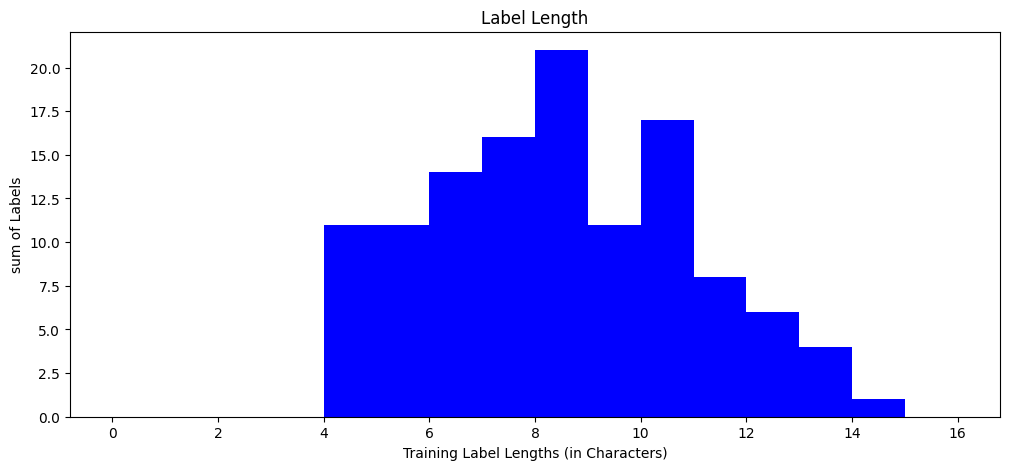

In [5]:
df['Label_len'] = df['Label'].str.len()

max_length_value = 15
df.hist("Label_len",
          grid=False,
          color="Blue",
          figsize=(12,5),
          bins=max_length_value + 1,
          range=(0, max_length_value + 1)
          )

plt.suptitle('')
plt.xlabel('Training Label Lengths (in Characters)')
plt.ylabel('sum of Labels')
plt.title('Label Length')
plt.show()

df = df.drop(columns=['Label_len'])

## Custom Dataset untuk Pytorch

In [6]:
# Dataset custom untuk PyTorch
class CustomDataset(Dataset):
  def __init__(self, dataframe, image_dir, processor):
      self.dataframe = dataframe
      self.image_dir = image_dir
      self.processor = processor

  def __len__(self):
      return len(self.dataframe)

  def __getitem__(self, idx):
      img_name = self.dataframe.iloc[idx, 0]
      label = self.dataframe.iloc[idx, 1]

      # Load image
      img_path = os.path.join(self.image_dir, img_name)
      image = Image.open(img_path).convert("RGB")
      image = image.resize((248, 76))  # Resize image

      # Preprocess image
      pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

      # Preprocess label
      labels = self.processor.tokenizer(label, return_tensors="pt", padding="max_length", truncation=True, max_length=64).input_ids.squeeze()

      return {
          'pixel_values': pixel_values,
          'labels': labels
      }

###Inisialisasi prosesor

In [7]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


##Split Dataset

In [16]:
from sklearn.model_selection import train_test_split

# Bagi dataset menjadi training dan validation set
train_df, eval_df = train_test_split(df, test_size=0.1)

# Buat dataset PyTorch untuk training dan evaluasi
train_dataset = CustomDataset(train_df, path, processor)
eval_dataset = CustomDataset(eval_df, path, processor)

### Buat dataset dengan dataloader sesuai kebutuhan torch

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4, shuffle=False)

##Setup Model dan Training

In [9]:
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

###Training arguments

In [12]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [13]:
!pip install accelerate -U

In [19]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    save_steps=30,
    eval_steps=15,
    logging_steps=15,
    output_dir="/content/trocr-finetuned",
    save_total_limit=2,
)

###Custom Data collator untuk data

In [20]:
# Custom collator untuk data
class DataCollatorForSeq2Seq:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, batch):
        pixel_values = torch.stack([item['pixel_values'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])

        return {
            'pixel_values': pixel_values,
            'labels': labels
        }

In [21]:
data_collator = DataCollatorForSeq2Seq(processor=processor)

## Training

In [22]:
# Inisialisasi trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

In [23]:
train_result = trainer.train()

Step,Training Loss,Validation Loss
15,0.344800,0.306331
30,0.291300,0.278900
45,0.205300,0.238609
60,0.194600,0.236688
75,0.147900,0.243870
